## Period estimation using the autocorrelation and autocorrentropy function


In this demo the autocorrelation function (ACF) and the information theoretic autocorrentropy function are used to estimate the periodicity of a signal from noisy samples. Autocorrentropy is a generalized autocorrelation function. Autocorrentropy is defined as
$$
V[m] = \mathbb{E_{x_n}} [G_{\sigma}(x_n - x_{n-m})],
$$
where $m$ is the lag, and $G_{\sigma}(\cdot)$ is the Gaussian kernel, although any positive-definite translation invariant kernel can be used.

Autocorrentropy with the Gaussian kernel includes all the even-order statistical moments of the random process $ \mathbb{E}[(X-Y)^{2k}], k \in \mathbb{N} $, in comparison ACF is based exclusively on the second order moment. This makes correntropy more robust to signals with non-Gaussian distributions and tolerant to outlier data points. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
f0 = 1.0
N = 1000
x = np.linspace(0.0, 10.0, num=N)
y = np.sin(2.0*np.pi*x)
nu1 = np.random.randn(N)
p = np.random.rand(N)
def auto_correlation(x, y):
    N = len(y)
    Fs = N/(x[-1]-x[0])
    max_lag = int(0.5*N)
    lag = np.arange(0.0, x[max_lag-1], step=1.0/Fs)
    c = np.zeros(shape=(max_lag,))
    mu_y = np.mean(y)
    for m in range(max_lag):
        for n in range(m, N):
            c[m] += (y[n]-mu_y)*(y[n-m]-mu_y)
        c[m] = c[m]/(N-m+1)
    return lag, c

def auto_correntropy(x, y, kernel_size_factor):
    N = len(y)
    iqr = np.percentile(y, 75) - np.percentile(y, 25)
    kernel_size = kernel_size_factor*1.06*np.amin([np.std(y), iqr/1.349])*N**(-0.2)
    Fs = N/(x[-1]-x[0])
    max_lag = int(0.5*N)
    lag = np.arange(0.0, x[max_lag-1], step=1.0/Fs)
    v = np.zeros(shape=(max_lag,))
    for m in range(max_lag):
        for n in range(m, N):
            v[m] += np.exp(-0.5*(y[n]-y[n-m])**2/kernel_size**2)
        v[m] = v[m]/(kernel_size*np.sqrt(2.0*np.pi)*(N-m+1))
    return lag, v

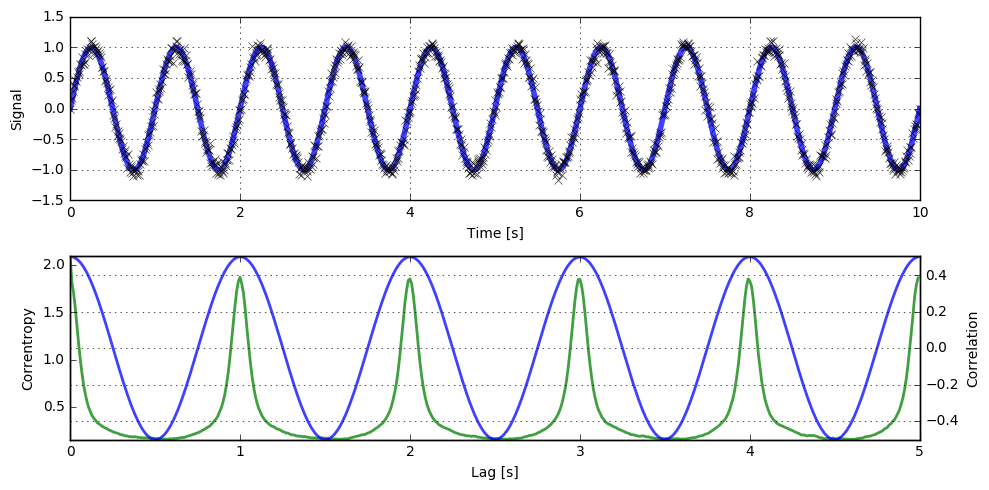

In [3]:
slider_snr = widgets.FloatSlider(description='SNR', value=2.0, 
                                 min=0.0, max=2.0, step=0.1, continuous_update=False)
slider_ks = widgets.FloatSlider(description='Kernel size factor', value=1.0, 
                                min=0.1, max=10.0, step=0.1, continuous_update=False)
slider_out = widgets.FloatSlider(description='Outlier th', value=0.0, 
                                min=0.0, max=0.5, step=0.1, continuous_update=False)
slider_snr.layout.width='60%'
slider_ks.layout.width='60%'
slider_out.layout.width='60%'
plt.close()
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(x, y, 'b-', linewidth=4, alpha=0.75)
z = y + nu1*np.sqrt(1.0/(2*10**slider_snr.value))
l1, = ax1.plot(x, z, 'kx', alpha=0.75)
ax1.set_ylabel('Signal')
ax1.set_xlabel('Time [s]')
plt.grid()
ax2 = fig.add_subplot(2, 1, 2)
ax3 = ax2.twinx()
lag, v = auto_correntropy(x, z, slider_ks.value)
lag, c = auto_correlation(x, z)
plt.grid()
l2, = ax2.plot(lag, v, 'g-', linewidth=2, alpha=0.75)
ax2.set_ylim([np.amin(v), np.amax(v)])
ax2.set_xlabel('Lag [s]')
ax2.set_ylabel('Correntropy')
ax3.set_ylabel('Correlation')
l3, = ax3.plot(lag, c, 'b-', linewidth=2, alpha=0.75)
ax3.set_ylim([np.amin(c), np.amax(c)])
plt.tight_layout()
display(widgets.VBox((slider_snr, slider_ks, slider_out)))
display(fig)

def callback_snr(change):
    SNR = change['new']
    z = y + nu1*np.sqrt(1.0/(2*10**SNR))
    out_pbb = slider_out.value
    z[p > 1.0 - out_pbb] += 10*np.std(z)
    l1.set_ydata(z)
    ks_factor = slider_ks.value
    lag, v = auto_correntropy(x, z, ks_factor)
    lag, c = auto_correlation(x, z)
    l2.set_ydata(v)
    ax2.set_ylim([np.amin(v), np.amax(v)])
    l3.set_ydata(c)
    ax3.set_ylim([np.amin(c), np.amax(c)])
    clear_output(wait=True)
    display(fig)
    
def callback_ks(change):
    ks_factor = change['new']
    out_pbb = slider_out.value
    SNR = slider_snr.value
    z = y + nu1*np.sqrt(1.0/(2*10**SNR))
    z[p > 1.0 - out_pbb] += 10*np.std(z)
    lag, v = auto_correntropy(x, z, ks_factor)
    l2.set_ydata(v)
    ax2.set_ylim([np.amin(v), np.amax(v)])
    clear_output(wait=True)
    display(fig)
    
def callback_out(change):
    out_pbb = change['new']
    SNR = slider_snr.value
    ks_factor = slider_ks.value
    z = y + nu1*np.sqrt(1.0/(2*10**SNR))
    z[p > 1.0 - out_pbb] += 10*np.std(z)
    lag, c = auto_correlation(x, z)
    lag, v = auto_correntropy(x, z, ks_factor)
    l1.set_ydata(z)
    l2.set_ydata(v)
    ax2.set_ylim([np.amin(v), np.amax(v)])
    l3.set_ydata(c)
    ax3.set_ylim([np.amin(c), np.amax(c)])
    clear_output(wait=True)
    display(fig)
    
slider_snr.observe(callback_snr, names='value')
slider_ks.observe(callback_ks, names='value')
slider_out.observe(callback_out, names='value')

# Notes
- Increase SNR to make the Gaussian white noise stronger with respect to the signal
- Increase Outlier th to increase the percentage of outlier data points
- The kernel size is always computed using the Silverman rule and then multiplied by "Kernel size factor"
- For larger Outlier th consider decreasing the kernel size
- For smaller SNR consider increasing the kernel size

For more information, please review

Jose Principe, ''Information Theoretic Learning'', Springer, 2010
http://www.springer.com/gp/book/9781441915696